In [1]:
from importlib import reload
import sys
import os
sys.path.insert(0, './..')
sys.path.insert(0, './../scripts')

In [2]:
from importlib import reload

import pickle
import time

import numpy as np
import tensorflow as tf
import logging
from scipy import integrate
from scipy import interpolate
from scipy import linalg
from scipy import sparse

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.axes_grid1 import make_axes_locatable

import plot_func as pf
import util_func as uf

import dev_ori_sel_RF
from dev_ori_sel_RF import data_dir,network,connectivity,dynamics_np,probe_RFs
from dev_ori_sel_RF.tools import misc,update_params_dict,gen_gaussian_random_field

2024-01-22 15:17:28.565181: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Please install GPU version of TF


# Analyze Responses, Get Phase and Orientation Tuning

In [3]:
config_dict,N4pop,Nlgnpop,Nret,Nlgn,N4,rA = uf.get_network_size('ffrec_stevens_bars')

MISC params_dict params_ffrec_stevens_bars {'Nret': 96, 'Nlgn': 96, 'N4': 96, 'N23': 1, 'Nvert': 1, 'runtime': 20000, 'dt': 1.0, 'tau': 1.0, 'num_lgn_paths': 4, 'gamma_lgn': 1.0, 'gamma_4': 1.0, 'gamma_23': 1.0, 'learning_rate_decay_const': 160000.0, 'saving_stepsize': 10000, 'plasticity_rule': 'activity_based', 'random_seed': 19, 'nonlinearity_l4': 'rectifier', 'nonlinearity_l23': 'rectifier', 'integrator': 'Euler', 'test_lowDsubset': False, 'developing_params': [], 'Inp_params': {'ndim': 25, 'radius': 3.0, 'width': 1.0, 'simulate_activity': 'dynamics_adaptive', 'pattern_duration': 20, 'avg_no_inp': 1, 'expanse_time': 1, 'init_radius': 0.3, 'mean_width': 0.3, 'onoff_corr_factor': 1.0, 'onoff_rel_weight': 1.0, 'input_type': 'stevens_bars_rect', 'off_bias_strength': 0.0, 'off_bias_region_size': 0.5, 'gain_control_params': {'sigma': 0.037, 'ampl': 1.0, 'noise': 0.0, 'profile': 'Gaussian', 'stevensetal': True}}, 'Wret_to_lgn_params': {'sigma1': 0.037, 'sigma2': 0.15, 'ampl1': 1.0, 'ampl2'

In [6]:
act = np.load('./../results/grating_responses/ffrec_stevens_bars/v19_local/rates_f=3.npy').reshape((1,4,8,2,N4,N4))
inp = np.load('./../results/grating_responses/ffrec_stevens_bars/v19_local/inputs_f=3.npy').reshape((1,4,8,2,N4,N4))

In [8]:
inp_F0,inp_F1,inp_phase = uf.calc_dc_ac_comp(inp[0],1)
inp_F1 *= 2
inp_modrat = inp_F1/inp_F0
inp_avg,inp_OS,inp_PO = uf.calc_dc_ac_comp(inp_F0,0)
inp_OS = inp_OS/inp_avg
inp_PO *= 180/(2*np.pi)

act_F0,act_F1,act_phase = uf.calc_dc_ac_comp(act[0],1)
act_F1 *= 2
act_modrat = act_F1/act_F0
act_avg,act_OS,act_PO = uf.calc_dc_ac_comp(act_F0,0)
act_OS = act_OS/act_avg
act_PO *= 180/(2*np.pi)

Text(0, 0.5, 'Phase-Avg L4 Response')

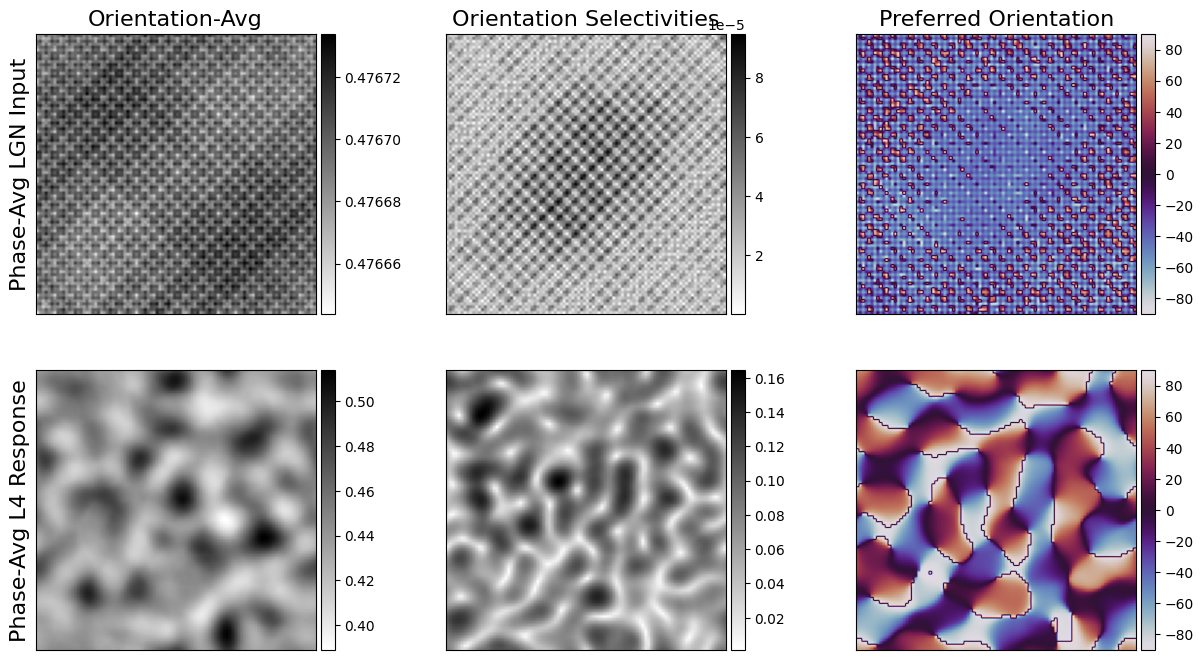

In [35]:
fig,axs = plt.subplots(2,3,figsize=(15,8))

pf.imshowbar(fig,axs[0,0],inp_avg[0],origin='lower',cmap='binary')
pf.imshowbar(fig,axs[0,1],inp_OS[0],origin='lower',cmap='binary')
pf.imshowbar(fig,axs[0,2],inp_PO[0],origin='lower',cmap='twilight',vmin=-90,vmax=90)
pf.imshowbar(fig,axs[1,0],act_avg[0],origin='lower',cmap='binary')
pf.imshowbar(fig,axs[1,1],act_OS[0],origin='lower',cmap='binary')
pf.imshowbar(fig,axs[1,2],act_PO[0],origin='lower',cmap='twilight',vmin=-90,vmax=90)

axs[0,0].set_title('Orientation-Avg',fontsize=16)
axs[0,1].set_title('Orientation Selectivities',fontsize=16)
axs[0,2].set_title('Preferred Orientation',fontsize=16)
axs[0,0].set_ylabel('Phase-Avg LGN Input',fontsize=16)
axs[1,0].set_ylabel('Phase-Avg L4 Response',fontsize=16)

Text(0, 0.5, 'Phase-Avg L4 Response')

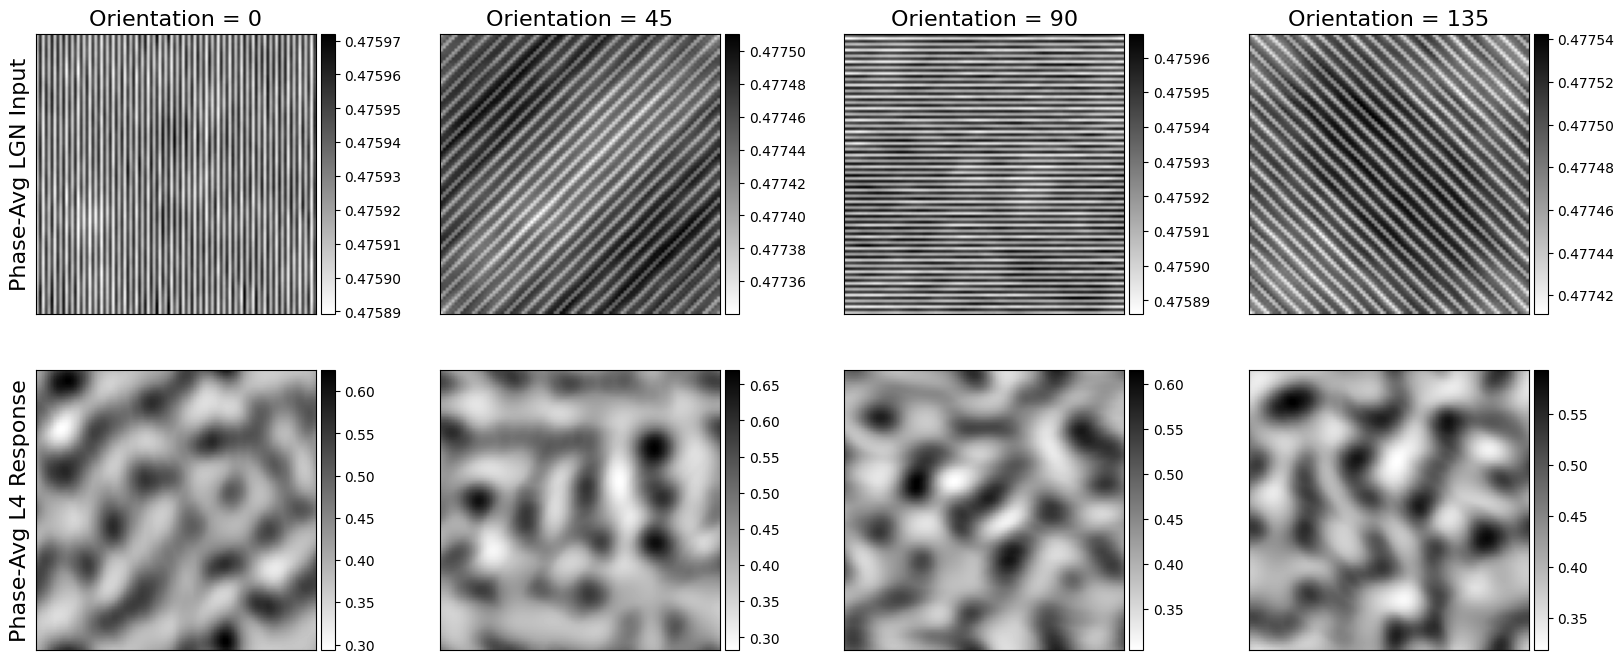

In [34]:
fig,axs = plt.subplots(2,4,figsize=(20,8))

for i in range(4):
    pf.imshowbar(fig,axs[0,i],inp_F0[i,0],origin='lower',cmap='binary')
    pf.imshowbar(fig,axs[1,i],act_F0[i,0],origin='lower',cmap='binary')
    
    axs[0,i].set_title('Orientation = {:d}'.format(i*180//4),fontsize=16)
axs[0,0].set_ylabel('Phase-Avg LGN Input',fontsize=16)
axs[1,0].set_ylabel('Phase-Avg L4 Response',fontsize=16)

In [26]:
model_acts = np.concatenate((
    np.load('./../results/grating_responses/ffrec_stevens_bars/v19_local/rates_f=3.npy').reshape((
        1,4,8,2,N4,N4))[:,:,:,:,:,:,None],
    np.load('./../results/grating_responses/ffrec_stevens_noinhplast_bars/v19_local/rates_f=3.npy').reshape((
        1,4,8,2,N4,N4))[:,:,:,:,:,:,None],
    np.load('./../results/grating_responses/ffrec_stevens_weak_bars/v19_local/rates_f=3.npy').reshape((
        1,4,8,2,N4,N4))[:,:,:,:,:,:,None]),axis=-1)

In [28]:
model_act_F0,model_act_F1,model_act_phase = uf.calc_dc_ac_comp(model_acts[0],1)
model_act_F1 *= 2
model_act_modrat = model_act_F1/model_act_F0

Text(0, 0.5, 'Weak Recurrent Strength')

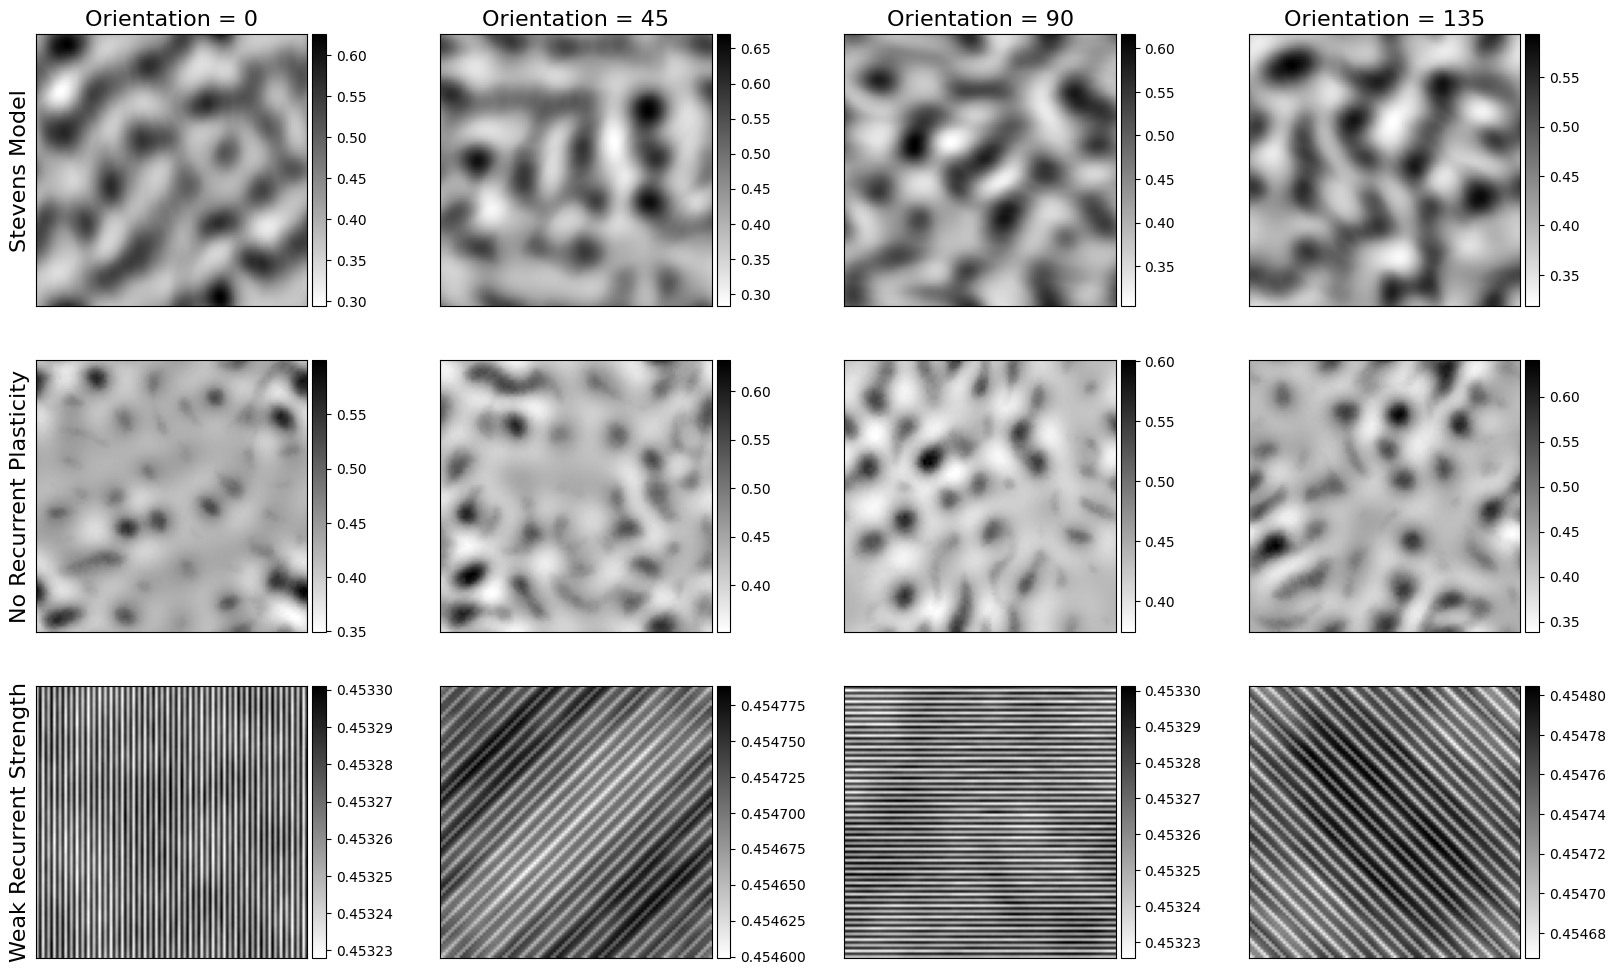

In [36]:
fig,axs = plt.subplots(3,4,figsize=(20,12))

for i in range(4):
    for j in range(3):
        pf.imshowbar(fig,axs[j,i],model_act_F0[i,0,:,:,j],origin='lower',cmap='binary')
    
    axs[0,i].set_title('Orientation = {:d}'.format(i*180//4),fontsize=16)
axs[0,0].set_ylabel('Stevens Model',fontsize=16)
axs[1,0].set_ylabel('No Recurrent Plasticity',fontsize=16)
axs[2,0].set_ylabel('Weak Recurrent Strength',fontsize=16)

Text(0, 0.5, 'Weak Recurrent Strength')

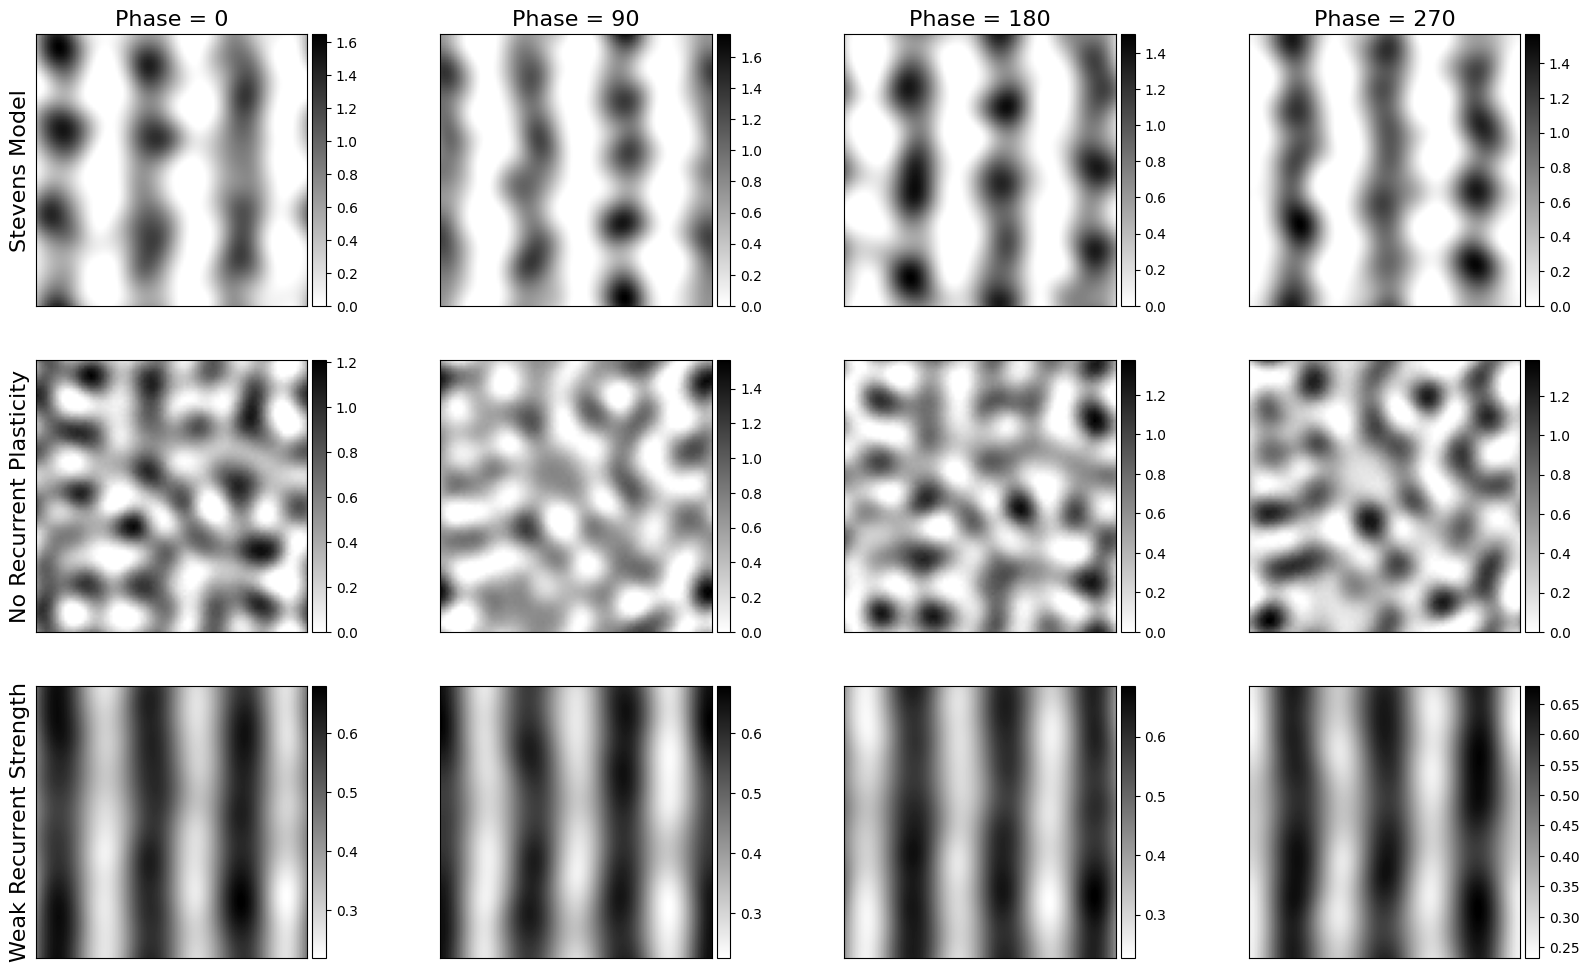

In [38]:
fig,axs = plt.subplots(3,4,figsize=(20,12))

for i in range(4):
    for j in range(3):
        pf.imshowbar(fig,axs[j,i],model_acts[0,0,2*i,0,:,:,j],origin='lower',cmap='binary')
    
    axs[0,i].set_title('Phase = {:d}'.format(i*360//4),fontsize=16)
axs[0,0].set_ylabel('Stevens Model',fontsize=16)
axs[1,0].set_ylabel('No Recurrent Plasticity',fontsize=16)
axs[2,0].set_ylabel('Weak Recurrent Strength',fontsize=16)